Please consider upvoting the dataset: https://www.kaggle.com/raddar/vinbigdata-competition-jpg-data-2x-downsampled

#### Detectron2 library can be used to quickly train object detection models. 
In this kernel, I will be refactoring code from detectron2's official github for this. Most of my code here is from: https://github.com/facebookresearch/detectron2/blob/master/tools/plain_train_net.py

Here, I am trying to make custom training loop without using detectrons's built in trainer. This would give me more control over the training.

At around 15,000 epochs, this model can give 0.2 lb score

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
%matplotlib inline

#### Object detection models require very large training iterations. Kaggle kernels have limited time allowed for continuous running of gpus. So I will be stopping the training when execution time approaches 3 hours

In [ ]:
# set start time
import time
kernel_start_time = time.time()

In [ ]:
!pip install detectron2 -f \
  https://dl.fbaipublicfiles.com/detectron2/wheels/cu102/torch1.7/index.html

### **** **Import everything**

In [ ]:
import detectron2
import cv2


import logging
from collections import OrderedDict
import torch
from torch.nn.parallel import DistributedDataParallel

import detectron2.utils.comm as comm
from detectron2.checkpoint import DetectionCheckpointer, PeriodicCheckpointer
from detectron2.config import get_cfg
from detectron2.data import (
    MetadataCatalog,
    build_detection_test_loader,
    build_detection_train_loader,
)
from detectron2.engine import default_argument_parser, default_setup, launch
from detectron2.evaluation import (
    COCOEvaluator,
    inference_on_dataset,
    print_csv_format,
)
from detectron2.modeling import build_model
from detectron2.solver import build_lr_scheduler, build_optimizer
from detectron2.utils.events import (
    CommonMetricPrinter,
    EventStorage,
    JSONWriter,
    TensorboardXWriter,
)

from detectron2.data import DatasetCatalog, MetadataCatalog
from tqdm import tqdm
import numpy as np
from detectron2 import model_zoo
from detectron2.structures import BoxMode
import detectron2.utils.comm as comm
from detectron2.engine import DefaultPredictor

### Configs

In [ ]:
# configs
DEBUG=False
TRAIN_CSV_PATH = "../input/vinbigdata-competition-jpg-data-2x-downsampled/train_downsampled.csv"
TRAIN_FOLDER = "../input/vinbigdata-competition-jpg-data-2x-downsampled/train/train"
EPOCHS =30000000 # set to high value. Training stops after around 2.5 hours
RUNTIME = 2.5*60*60 # SECONDS
# RUNTIME = 1*60*60
EVALUATE_EVERY_N_STEPS = 15
OUTPUT_DIR="outputs"

In [ ]:
traindf = pd.read_csv(TRAIN_CSV_PATH)
traindf.sample(2)

### Validation split

In [ ]:
from sklearn import model_selection
gkf = model_selection.GroupKFold(5)
for train_index, test_index in gkf.split(X=traindf,  groups=traindf["image_id"]):
    dftrain_val = traindf.loc[test_index,:]
    dftrain_tr = traindf.loc[train_index,:]
    break

dftrain_tr.shape,dftrain_val.shape

### Format data
Detectron2 data prep: create list of dicts  
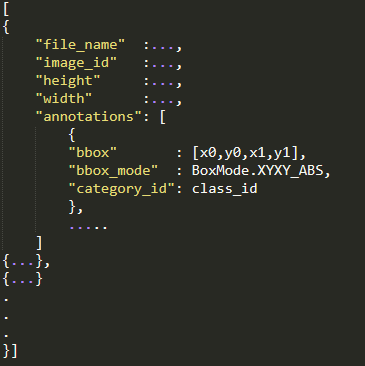

In [ ]:
def get_train_dicts(df):
    dataset_dicts = []
    for idx, img_id in enumerate(df["image_id"].unique()):
        record ={}
        filename = os.path.join(TRAIN_FOLDER,img_id+".jpg")
        record["file_name"] = filename
        # print(filename)
        h,w = cv2.imread(filename).shape[:2]
        h_ratio = 0.5
        w_ratio = 0.5
        record["image_id"] = img_id
        record["height"] = h
        record["width"] = w
        objects = []
        try:
            for _,row in df[df["image_id"]==img_id].iterrows():
                object_ = {
                    "bbox" : [int(row["x_min"])*w_ratio,int(row["y_min"])*h_ratio,int(row["x_max"])*w_ratio,int(row["y_max"])*h_ratio],
                    "bbox_mode" : BoxMode.XYXY_ABS,
                    "category_id" : row["class_id"]
                }
                objects.append(object_)
        except:
            objects = []
            pass
        record["annotations"] = objects
        dataset_dicts.append(record)
    return dataset_dicts
# get_train_dicts(dftrain_val_sampled)
classes = dftrain_tr[["class_id","class_name"]].drop_duplicates().sort_values("class_id")
print(classes[classes["class_name"]!="No finding"]["class_id"].tolist())
classes = classes[classes["class_name"]!="No finding"]["class_name"].tolist()
classes

### Register Dataset

In [ ]:
if DEBUG == True:
    nsample = 200
    train_sampled = []
    for class_ in classes+["No finding"]:
        sampledimids = np.random.choice(dftrain_tr[dftrain_tr["class_name"]==class_]["image_id"].unique(),nsample)
        train_sampled.extend(sampledimids)
    dftrain_tr_sampled = dftrain_tr[dftrain_tr["image_id"].isin(train_sampled)]


    nsample = 100
    val_sampled = []
    for class_ in classes+["No finding"]:
        sampledimids = np.random.choice(dftrain_val[dftrain_val["class_name"]==class_]["image_id"].unique(),nsample)
        val_sampled.extend(sampledimids)
    dftrain_val_sampled = dftrain_val[dftrain_val["image_id"].isin(val_sampled)]
    print(dftrain_tr_sampled.shape,dftrain_val_sampled.shape)

    d= "train"
    DatasetCatalog.register("vin_" + d, lambda d=d: get_train_dicts(dftrain_tr_sampled))
    MetadataCatalog.get("vin_" + d).set(thing_classes=classes)
    d= "val"
    DatasetCatalog.register("vin_" + d, lambda d=d: get_train_dicts(dftrain_val_sampled))
    MetadataCatalog.get("vin_" + d).set(thing_classes=classes,evaluator_type="coco")
    
else:
    d= "train"
    DatasetCatalog.register("vin_" + d, lambda d=d: get_train_dicts(dftrain_tr))
    MetadataCatalog.get("vin_" + d).set(thing_classes=classes)
    d= "val"
    DatasetCatalog.register("vin_" + d, lambda d=d: get_train_dicts(dftrain_val))
    MetadataCatalog.get("vin_" + d).set(thing_classes=classes,evaluator_type="coco")
    

### Prepare detectron2 config
Potential for hyperparameter tuning

In [ ]:
os.makedirs(OUTPUT_DIR,exist_ok=True) 
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")) # Pretrained model
cfg.DATASETS.TRAIN = ("vin_train",)
cfg.DATASETS.TEST = ("vin_val",)
cfg.DATALOADER.FILTER_EMPTY_ANNOTATIONS=False #negative samples also included
cfg.DATALOADER.NUM_WORKERS = 4
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")  
cfg.SOLVER.IMS_PER_BATCH = 8
cfg.SOLVER.BASE_LR = 0.00025  
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512  
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 14
cfg.OUTPUT_DIR=OUTPUT_DIR
print(cfg)

### Build model, optimizer, scheduler, checkpointer(for saving model), writer(logging), data loader

In [ ]:
# set up model,optimizers,scheduler
model = build_model(cfg)
model.train()
optimizer = build_optimizer(cfg, model)
scheduler = build_lr_scheduler(cfg, optimizer)
# checkpointer helps in saving --> checkpointer.save('filename.pth')
checkpointer = DetectionCheckpointer(
        model, cfg.OUTPUT_DIR, optimizer=optimizer, scheduler=scheduler
    )
# writer object saves loss metrics
writer = JSONWriter(os.path.join( "test_metrics2.json"))
data_loader = build_detection_train_loader(cfg)

### Evaluation function for calculating coco metrics: APmean, AP50...

In [ ]:
def do_evaluate(cfg, model):
    results = OrderedDict()
    for dataset_name in cfg.DATASETS.TEST:
        print(dataset_name)
        data_loader = build_detection_test_loader(cfg, dataset_name)
        evaluator = COCOEvaluator(dataset_name, cfg, True, "inference")
        results_i = inference_on_dataset(model, data_loader, evaluator)
        results[dataset_name] = results_i
        print(results)
        if comm.is_main_process():
            logger.info("Evaluation results for {} in csv format:".format(dataset_name))
            print_csv_format(results_i)
    if len(results) == 1:
        results = list(results.values())[0]
    return results

### Training Loop
Points to note:
* Training loop needs to be included inside an EventStorage block.
* storage to be 'steped' after every epoch
* storage.put_scalars() + writer.write() records loss in json file
* for loss calculation :refer https://github.com/facebookresearch/detectron2/blob/master/tools/plain_train_net.py
* checkpointer.save(filename) saves file to cfg.OUTPUT_DIR


In [ ]:
loss_list = []
eval_list = []
total_loss_list = []
logger = logging.getLogger("detectron2")
os.makedirs(OUTPUT_DIR,exist_ok=True)
with EventStorage(0) as storage:
    for data, iteration in zip(data_loader, range(0, EPOCHS)):
        storage.step() #--.needed
#         print(iteration)
        
        loss_dict = model(data)
#         print(loss_dict)
        losses = sum(loss for loss in loss_dict.values())
#         print(losses)
        loss_dict_reduced = {k: v.item() for k, v in comm.reduce_dict(loss_dict).items()}
#         print(loss_dict_reduced)
        losses_reduced = sum(loss for loss in loss_dict_reduced.values())
#         print(losses_reduced)
        loss_list.append(loss_dict_reduced)
        total_loss_list.append(losses_reduced)
        # break

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        scheduler.step()
        storage.put_scalars(total_loss=losses_reduced, **loss_dict_reduced)
        writer.write()
        if iteration % EVALUATE_EVERY_N_STEPS==0:
            results = do_evaluate(cfg, model)
    #         print(results)
            eval_list.append(results["bbox"])
            checkpointer.save("model_final") 
        if (time.time() - kernel_start_time) >RUNTIME:
            print("time uppp")
            break

In [ ]:
df_loss = pd.DataFrame(loss_list)
df_eval = pd.DataFrame(eval_list)
df_totloss = pd.DataFrame({"tot_loss":total_loss_list})
df_totloss.plot()

In [ ]:
df_eval["AP50"].plot()

## Evaluate

Evaluation config

In [ ]:

cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0
cfg.MODEL.ROI_HEADS.NMS_THRESH_TEST = 0.4
predictor = DefaultPredictor(cfg)


In [ ]:
from detectron2.utils.visualizer import Visualizer
from detectron2.utils.visualizer import ColorMode
import random
model.eval()
val_dict = DatasetCatalog.get("vin_val")
val_metadata = MetadataCatalog.get("vin_val")
for d in random.sample(val_dict, 10):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=val_metadata, scale=1)
    out = visualizer.draw_dataset_dict(d)
    plt.imshow(out.get_image())
    plt.show()
    outputs = predictor(img)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(img[:, :, ::-1],
                   metadata=val_metadata, 
                   scale=1, 
                   )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.imshow(out.get_image())
    plt.show()
    print("-------------------------")

In [ ]:
df_loss.to_csv("loss_list.csv")
df_eval.to_csv("eval_list.csv")
df_totloss.to_csv("total_loss_list.csv")